###드라이브마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 파일 압축해제

In [ ]:
# 구글드라이브에 이미 압축 해제된 상태로 존재해서 주석처리 - 태영
# import zipfile

# # 파일 경로 입력
# zip_file_name = '/content/drive/MyDrive/my_data/Birdclef2024/birdclef-2024.zip'

# # 압축 해제할 경로 입력(드라이브 밖에 폴더로 설정해야함)
# extraction_dir = '/content/data'

# # 압축 해제
# with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
#     zip_ref.extractall(extraction_dir)


# BASE_PATH = '/content/data'


###라이브러리

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchaudio

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### CFG

In [ ]:
class CFG:
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 2048
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'

    # Data augmentation parameters
    augment=True

    num_classes = 182

    LEARNING_RATE = 1e-3,

    # Class Labels for BirdCLEF 24
    class_names = ['asbfly','ashdro1','ashpri1','ashwoo2','asikoe2','asiope1','aspfly1','aspswi1','barfly1','barswa','bcnher','bkcbul1','bkrfla1','bkskit1','bkwsti',
                   'bladro1','blaeag1','blakit1','blhori1','blnmon1','blrwar1','bncwoo3','brakit1','brasta1','brcful1','brfowl1','brnhao1','brnshr','brodro1','brwjac1',
                   'brwowl1','btbeat1','bwfshr1','categr','chbeat1','cohcuc1','comfla1','comgre','comior1','comkin1','commoo3','commyn','compea','comros','comsan','comtai1',
                   'copbar1','crbsun2','cregos1','crfbar1','crseag1','dafbab1','darter2','eaywag1','emedov2','eucdov','eurbla2','eurcoo','forwag1','gargan','gloibi','goflea1',
                   'graher1','grbeat1','grecou1','greegr','grefla1','grehor1','grejun2','grenig1','grewar3','grnsan','grnwar1','grtdro1','gryfra','grynig2','grywag','gybpri1',
                   'gyhcaf1','heswoo1','hoopoe','houcro1','houspa','inbrob1','indpit1','indrob1','indrol2','indtit1','ingori1','inpher1','insbab1','insowl1','integr','isbduc1',
                   'jerbus2','junbab2','junmyn1','junowl1','kenplo1','kerlau2','labcro1','laudov1','lblwar1','lesyel1','lewduc1','lirplo','litegr','litgre1','litspi1','litswi1',
                   'lobsun2','maghor2','malpar1','maltro1','malwoo1','marsan','mawthr1','moipig1','nilfly2','niwpig1','nutman','orihob2','oripip1','pabflo1','paisto1','piebus1',
                   'piekin1','placuc3','plaflo1','plapri1','plhpar1','pomgrp2','purher1','pursun3','pursun4','purswa3','putbab1','redspu1','rerswa1','revbul','rewbul','rewlap1',
                   'rocpig','rorpar','rossta2','rufbab3','ruftre2','rufwoo2','rutfly6','sbeowl1','scamin3','shikra1','smamin1','sohmyn1','spepic1','spodov','spoowl1','sqtbul1',
                   'stbkin1','sttwoo1','thbwar1','tibfly3','tilwar1','vefnut1','vehpar1','wbbfly1','wemhar1','whbbul2','whbsho3','whbtre1','whbwag1','whbwat1','whbwoo2','whcbar1',
                   'whiter2','whrmun','whtkin2','woosan','wynlau1','yebbab1','yebbul3','zitcis1']  # train_audio내의 전체 폴더명
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

###시드 설정

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.seed) # Seed 고정

### 데이터로드

In [ ]:
#BASE_PATH = '/content/drive/MyDrive/my_data/Birdclef2024'

# 구글드라이브에 맞게 수정했음 - 강태영
BASE_PATH = '/content/drive/MyDrive/birdclef/birdclef-2024'

train_meta = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
train_meta['filepath'] = BASE_PATH + '/train_audio/' + train_meta.filename
train_meta['target'] = train_meta.primary_label.map(CFG.name2label)
train_meta['filename'] = train_meta.filepath.map(lambda x: x.split('/')[-1])
train_meta['xc_id'] = train_meta.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rows
train_meta["target"].value_counts()

target
181    500
105    500
107    500
37     500
39     500
      ... 
16       6
178      6
119      5
5        5
92       5
Name: count, Length: 182, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_meta, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 19567 | Num Valid: 4892


### 스펙토그램

In [ ]:
def load_audio(filepath):
    waveform, sr = torchaudio.load(filepath)
    if waveform.shape[0] > 1:  # stereo -> mono
        waveform = waveform[0:1, :]
    return waveform, sr

def crop_or_pad(waveform, target_len):
    audio_len = waveform.shape[1]
    if audio_len < target_len:
        pad_len = target_len - audio_len
        pad_start = random.randint(0, pad_len)
        pad_end = pad_len - pad_start
        waveform = F.pad(waveform, (pad_start, pad_end), mode="constant")
    elif audio_len > target_len:
        start = random.randint(0, audio_len - target_len)
        waveform = waveform[:, start:start + target_len]
    return waveform

def get_spectrogram(waveform):
    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=CFG.sample_rate,
        n_fft=CFG.nfft,
        win_length=CFG.window,
        hop_length=CFG.hop_length,
        f_min=CFG.fmin,
        f_max=CFG.fmax,
        n_mels=CFG.img_size[0]
    )
    spec = transform(waveform)
    spec = torchaudio.transforms.AmplitudeToDB()(spec)
    spec = (spec - spec.min()) / (spec.max() - spec.min())
    return spec

def get_target(target, num_classes):
    target = torch.tensor(target)
    return target

## 어그멘테이션 / mixup, randomcutout

In [ ]:
def mixup(data, targets, alpha=0.4):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = lam * data + (1 - lam) * shuffled_data
    targets = lam * targets + (1 - lam) * shuffled_targets

    return data, targets

def random_cutout(spec, height_factor=(0.06, 1.0), width_factor=(0.06, 1.0)):
    _, h, w = spec.shape
    cutout_h = random.randint(int(h * height_factor[0]), int(h * height_factor[1]))
    cutout_w = random.randint(int(w * width_factor[0]), int(w * width_factor[1]))

    cutout_x = random.randint(0, w - cutout_w)
    cutout_y = random.randint(0, h - cutout_h)

    spec[:, cutout_y:cutout_y + cutout_h, cutout_x:cutout_x + cutout_w] = 0

    return spec


class AudioDataset(Dataset):
    def __init__(self, filepaths, labels=None, transform=None, with_labels=True, augment=False):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform
        self.with_labels = with_labels
        self.augment = augment

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        waveform, sr = load_audio(filepath)
        waveform = crop_or_pad(waveform, CFG.audio_len)

        spec = get_spectrogram(waveform)
        spec = spec.repeat(3, 1, 1)  # 스펙트로그램을 3채널 이미지로 변환

        if self.augment:
            if random.random() > 0.5:
                spec = random_cutout(spec, height_factor=(1.0, 1.0), width_factor=(0.06, 0.12))
            else:
                spec = random_cutout(spec, height_factor=(0.06, 0.1), width_factor=(1.0, 1.0))

        if self.transform:
            spec = self.transform(spec)

        if self.with_labels:
            label = get_target(self.labels[idx], CFG.num_classes)
            return spec, label
        else:
            return spec


In [ ]:
def build_dataloader(filepaths, labels=None, batch_size=32, shuffle=True, augment=True):
    dataset = AudioDataset(filepaths, labels, transform=None, with_labels=labels is not None, augment=augment)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [ ]:
# 파일 경로와 레이블
train_filepaths = train_meta['filepath'].values
train_labels = train_meta['target'].values

valid_filepaths = valid_df['filepath'].values
valid_labels = valid_df['target'].values

# 데이터 로더 생성
train_loader = build_dataloader(train_filepaths, train_labels, batch_size=CFG.batch_size, shuffle=True, augment=True)
valid_loader = build_dataloader(valid_filepaths, valid_labels, batch_size=CFG.batch_size, shuffle=False, augment=False)

In [ ]:
from sklearn.metrics import accuracy_score


class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_score_min = np.Inf

    def __call__(self, val_score, model, model_path):
        score = val_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(score, model, model_path)

    def save_checkpoint(self, val_score, model, model_path):
        if val_score < self.val_score_min:
            print(f'Validation score decreased ({self.val_score_min:.6f} --> {val_score:.6f}).  Saving model ...')
            torch.save(model.state_dict(), model_path)
        self.val_score_min = val_score

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    early_stop = EarlyStopping(patience=3, delta=0.001)
    best_val_score = 0
    best_model = None

    train_loss_epoch, valid_loss_epoch, valid_score_epoch = [], [], []
    for epoch in range(1, CFG.epochs+1):
        model.train() # 모델을 학습모드로
        train_loss = []
        for images, labels in tqdm(iter(train_loader)):
            #print(labels)
            #print(labels.shape)
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)

        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val ACC : [{_val_score:.5f}]')

        train_loss_epoch.append(_train_loss)
        valid_loss_epoch.append(_val_loss)
        valid_score_epoch.append(_val_score)

        if scheduler is not None:
            scheduler.step(_val_score)

        early_stop(_val_score, model, '/content/drive/MyDrive/my_data/Birdclef2024/best_model.pth')

        if early_stop.early_stop:
            print("Early stopping")
            break

        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            print('***** Best Model *****')
            torch.save(best_model.state_dict(), '/content/drive/MyDrive/my_data/Birdclef2024/best_model.pth')

    return best_model, train_loss_epoch, valid_loss_epoch, valid_score_epoch

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []

    with torch.no_grad():
        for images, labels in tqdm(iter(val_loader)):
            images = images.to(device)
            labels = labels.to(device)

            logit = model(images)

            loss = criterion(logit, labels)

            val_loss.append(loss.item())

            #preds += torch.softmax(logit, dim=1).detach().cpu().numpy().tolist()

            preds += torch.softmax(logit, dim=1).argmax(1).detach().cpu().numpy().tolist()

            #print('probs==',preds)

            #preds += logit.argmax(1).detach().cpu().numpy().tolist()
            #print('preds=====',preds)




            trues += labels.detach().cpu().numpy().tolist()
            #print('trues=====',trues)

    #print(preds)
    #print(trues)
    _val_loss = np.mean(val_loss)
    #_val_score = f1_score(trues, preds, average='macro')
    #_val_score = roc_auc_score(trues, preds, average='macro')
    #_val_score = roc_auc_score(trues, preds, average='macro')
    #_val_score = roc_auc_score(trues, probs, average='macro',multi_class='ovr')
    _val_score = accuracy_score(trues, preds)

    return _val_loss, _val_score

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            images = images.to(device)

            logit = model(images)

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

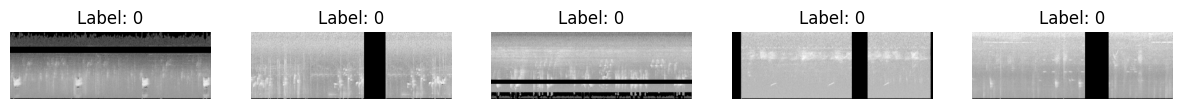

In [ ]:
def show_augmented_spectrograms(dataloader, num_samples=5):
    dataset = dataloader.dataset
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        spec, label = dataset[i]
        spec = spec.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

        axes[i].imshow(spec)
        axes[i].set_title(f"Label: {label.item()}")
        axes[i].axis('off')

    plt.show()

# 어그멘테이션이 적용된 데이터 로더에서 샘플 가져오기
show_augmented_spectrograms(train_loader, num_samples=5)

모델 불러오기

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 182)

In [ ]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, valid_loader, scheduler, device)



  0%|          | 0/383 [00:00<?, ?it/s]

KeyboardInterrupt: 

모델 직접 구현하기

In [ ]:
# 없으면 torchvision설치
# !pip install torch torchvision

import torch
import torch.nn as nn
from torch import Tensor
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, resnext101_64x4d, wide_resnet50_2, wide_resnet101_2
import torchvision.transforms as transforms
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

__all__ = [
    "ResNet",
    "ResNet18_Weights",
    "ResNet34_Weights",
    "ResNet50_Weights",
    "ResNet101_Weights",
    "ResNet152_Weights",
    "ResNeXt50_32X4D_Weights",
    "ResNeXt101_32X8D_Weights",
    "ResNeXt101_64X4D_Weights",
    "Wide_ResNet50_2_Weights",
    "Wide_ResNet101_2_Weights",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "resnext101_64x4d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]

# Example of an Image Classification Transform
ImageClassificationTransform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def _log_api_usage_once(obj):
    pass

def _ovewrite_named_param(kwargs, param, new_value):
    if param in kwargs:
        kwargs[param] = new_value
    return kwargs

def handle_legacy_interface(**kwargs):
    pass

_IMAGENET_CATEGORIES = ['cat', 'dog']  # Example categories, replace with actual categories if needed

class Weights:
    def __init__(self, path, transforms, meta):
        self.path = path
        self.transforms = transforms
        self.meta = meta

    def get_state_dict(self, progress=True, check_hash=True):
        state_dict = torch.load(self.path)
        return state_dict

class WeightsEnum:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __getattr__(self, name):
        return self.__dict__[name]

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model

_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}

class ResNet18_Weights(WeightsEnum):
    LOCAL = Weights(
        # 사용해야되는 pth파일 경로
        path="/content/drive/MyDrive/my_data/Birdclef2024/best_model.pth",
        transforms=partial(transforms.Compose, [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        meta={
            **_COMMON_META,
            "num_params": 11689512,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 69.758,
                    "acc@5": 89.078,
                }
            },
            "_ops": 1.814,
            "_file_size": 44.661,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = LOCAL

# 사용 예제
model = resnet18()
model.fc = nn.Linear(512, 182)
weights = ResNet18_Weights.LOCAL
state_dict = weights.get_state_dict()
model.load_state_dict(state_dict)


In [ ]:
model

불러온 모델 확인용 학습

In [ ]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, valid_loader, scheduler, device)